In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader
import time
import sys
import pandas as pd
import tensorflow as tf
from scipy.ndimage import gaussian_filter

In [2]:
# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [3]:
dataset = np.load('/kaggle/input/2d-inverse-designed-3db-directional-coupler-250/2d_dc_dataset_480.npy', allow_pickle=True)
design_dataset0 = dataset[:,0]

In [4]:
design_dataset=[]
for i in range(len(design_dataset0)):
    design_dataset.append(design_dataset0[i])
design_dataset=np.array(design_dataset)
design_dataset=torch.from_numpy(design_dataset)

In [5]:
design_dataset.shape

torch.Size([480, 400, 200])

In [6]:
design_dataset.shape

torch.Size([480, 400, 200])

In [7]:
original_width=design_dataset.shape[2]
down_scaled_width=int(design_dataset.shape[2]/4)
training_dataset=T.functional.resize(design_dataset,down_scaled_width) #nn.functional.interpolate(design_dataset,down_scaled_width)

#design_dataset=design_dataset.reshape(-1,1,400,200)
#training_dataset = F.interpolate(design_dataset,scale_factor=0.25)
training_dataset2=T.functional.resize(training_dataset,original_width)


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


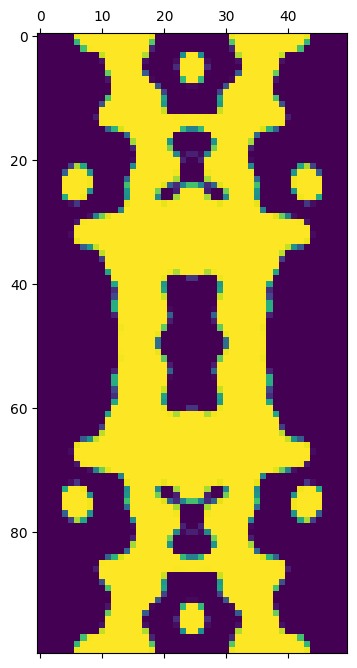

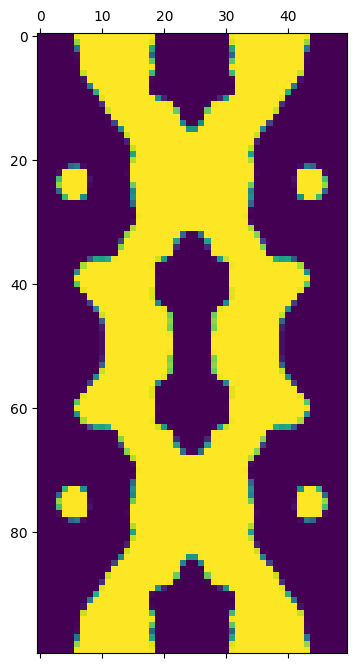

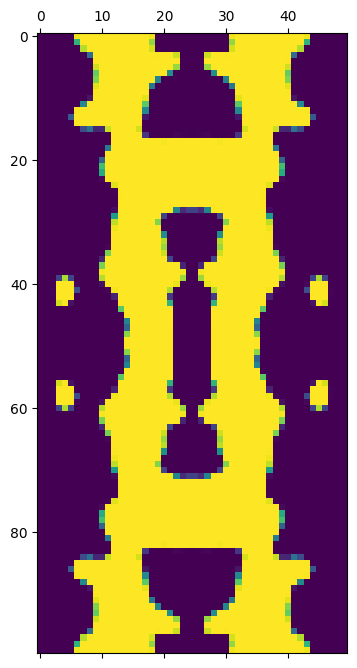

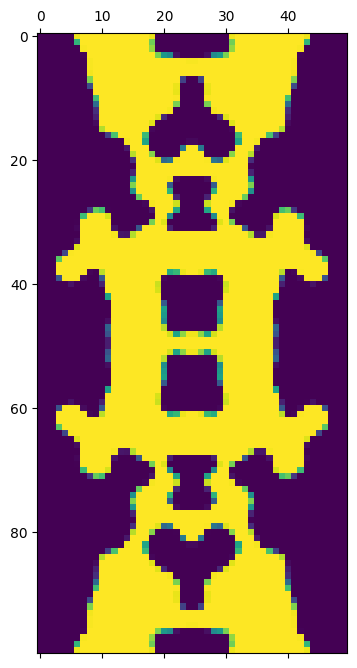

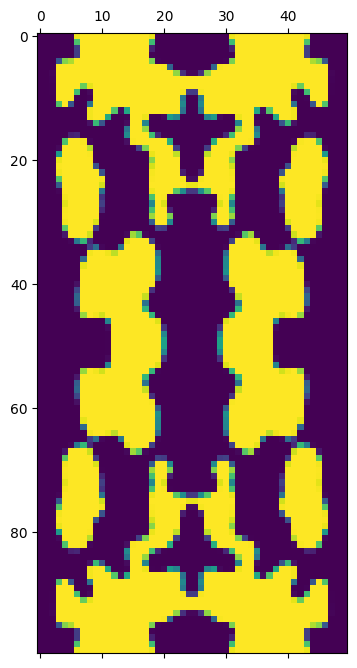

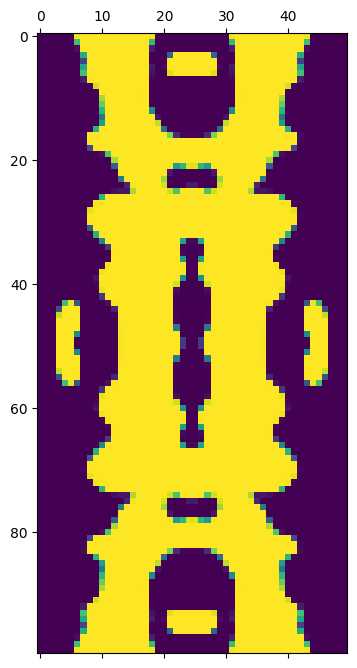

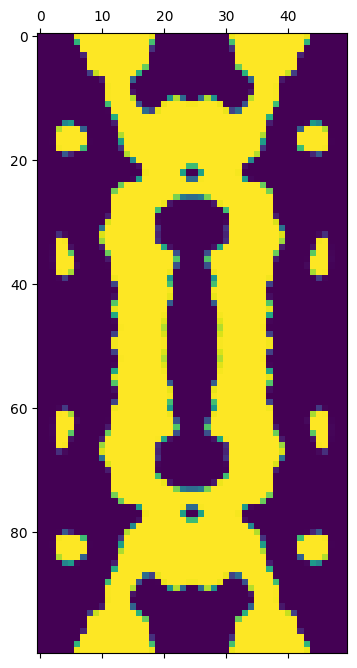

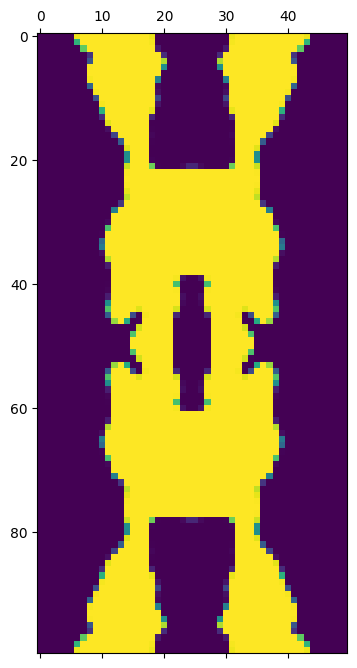

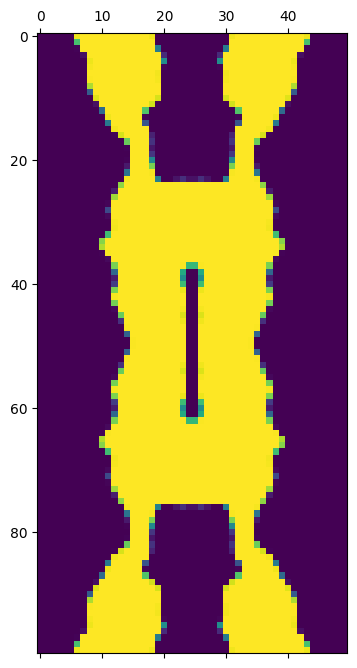

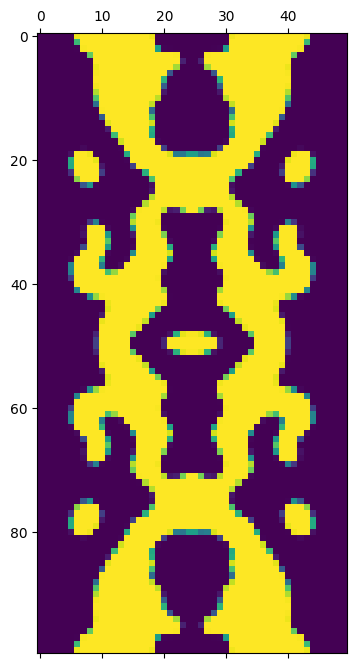

In [43]:
for i in range(10): 
    output=training_dataset[np.random.randint(480)]
    #output=gaussian_filter(output, sigma=1)
    #output=projection(torch.Tensor(output))
    plt.matshow(output)
    


In [9]:
#design_dataset.shape
training_dataset.shape


torch.Size([480, 100, 50])

In [10]:
#quarter_design_dataset = design_dataset[:,:200,:100]
#quarter_design_dataset.shape

quarter_training_dataset = training_dataset[:,:int(down_scaled_width*2/2),:int(down_scaled_width/2)]
quarter_training_dataset.shape

torch.Size([480, 50, 25])

In [11]:
#quarter_design_dataset = quarter_design_dataset.reshape(len(quarter_design_dataset),-1)
#quarter_design_dataset.shape

quarter_training_dataset = quarter_training_dataset.reshape(len(quarter_training_dataset),-1)
quarter_training_dataset.shape

torch.Size([480, 1250])

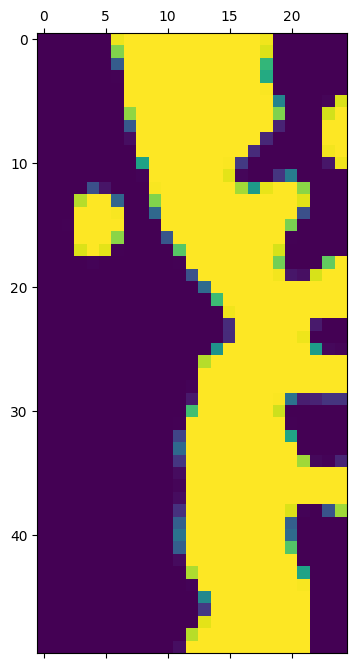

In [12]:
plt.matshow(quarter_training_dataset[40].reshape(int(down_scaled_width*2/2),int(down_scaled_width/2)))


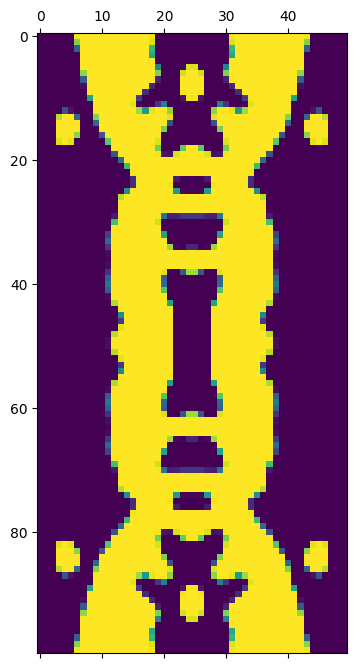

In [13]:
top_left = quarter_training_dataset[40].reshape(int(down_scaled_width*2/2),int(down_scaled_width/2)) #quarter_design_dataset[40].reshape(200,100)
bottom_left = torch.flipud(top_left)
top_right = torch.fliplr(top_left)
bottom_right = torch.flipud(top_right)

top_half = torch.concatenate((top_left,top_right), axis=1)
bottom_half = torch.concatenate((bottom_left,bottom_right), axis=1)

full_design = torch.concatenate((top_half,bottom_half), axis=0)


plt.matshow(full_design) 

In [14]:
full_design.shape


torch.Size([100, 50])

In [15]:
def design_recover(x): # for torch, replace np with torch
    top_left = x.reshape(int(down_scaled_width*2/2),int(down_scaled_width/2)) #x.reshape(200,100)
    bottom_left = np.flipud(top_left)
    top_right = np.fliplr(top_left)
    bottom_right = np.flipud(top_right)
    top_half = np.concatenate((top_left,top_right), axis=1)
    bottom_half = np.concatenate((bottom_left,bottom_right), axis=1)

    full_design = np.concatenate((top_half,bottom_half), axis=0)
    
    return full_design

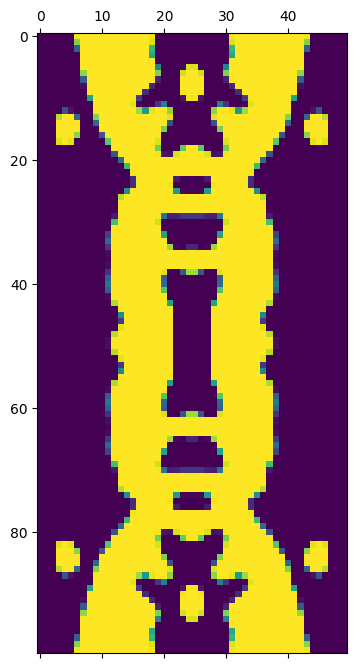

In [16]:
#plt.matshow(design_recover(quarter_design_dataset[40].cpu().detach().numpy()))
plt.matshow(design_recover(quarter_training_dataset[40].cpu().detach().numpy()))


In [17]:
##FOR IMPLEMENTING STRAIGHT THROUGH BVAE

class binarization(torch.autograd.Function):
    
    @staticmethod
    def forward(self,input):
        a=input.clone()
        a[a>0.5]=torch.tensor([1-(1e-5)])
        a[a<0.5]=torch.tensor([0+1e-5])
        return a

        
    @staticmethod
    def backward(self,grad_output):
        grad_input = grad_output.clone()
        return grad_i

In [18]:
class bVAE(nn.Module):
  def __init__(self,latent_dim):
    super(bVAE, self).__init__()
    
    self.encoder=nn.Sequential(
        nn.Linear(input_size,512),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.5),

        nn.Linear(512,256),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.5),

        nn.Linear(256,latent_dim),
        nn.Sigmoid(),
    )

    self.decoder=nn.Sequential(
        nn.Linear(latent_dim,256),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.5),

        nn.Linear(256,512),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.5),

        nn.Linear(512,input_size),
        nn.Sigmoid()
    )

  def encode(self,x):
    a= self.encoder(x)
    a=torch.clamp(a,min=1e-5,max=1-1e-5)
    return a

  def gumbel_reparam(self,a,lambd): # takes in the input from the encoder
    lambd=lambd.to(DEVICE)
    a=torch.clamp(a,min=1e-5,max=1-1e-5).to(DEVICE)
    u=torch.clamp(torch.rand(a.size()),min=1e-5,max=1-1e-5).to(DEVICE)
    x=((torch.log(a/(1-a))+torch.log(u/(1-u)))/lambd).to(DEVICE)
    x=torch.sigmoid(x)
    x=torch.clamp(x,min=1e-5,max=1-1e-5)
    return x



  def decode(self,x):
    d=self.decoder(x)
    return d


  def forward(self,x):
    e=self.encode(x)
    g=self.gumbel_reparam(e,lambd)
    b=binarization.apply(g)
    d=self.decode(g)
    return d,b,g,e

In [19]:
input_size=1250
latent_dim=500
LEARNING_RATE=1e-3

num_epochs=2000

lambd=torch.Tensor([5.0])
lambd_min=torch.Tensor([0.45])
lambd_learning_rate=torch.Tensor([3e-4])


model=bVAE(latent_dim)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [20]:
beta=1

def compute_loss(model,x,beta=0):
    x_hat,bi,gumbell,a=model(x+torch.rand(x.size()).to(DEVICE))
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=F.mse_loss(x,x_hat)
    #loss=nn.BCELoss()
    
    #reconstruction_loss=loss(x_hat,x)
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a)))
    total_loss=reconstruction_loss+beta*KL_loss
    return total_loss,reconstruction_loss,KL_loss

def compute_loss2(model,x): ### WRONG!!!! CHECK THE AXIS OF KL_LOSS...should be 1
    x_hat,bi,gumbell,a=model(x)
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=torch.mean(F.mse_loss(x,x_hat))
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=0))
    total_loss=reconstruction_loss+beta*KL_loss
    return total_loss,reconstruction_loss,KL_loss


def compute_loss_batch(model,x, beta=1):
#!!!!!!!!!#### befor runing check x and x1 always
    x=x.float()
    x_hat,bi,gumbell,a=model(x)
    ####### gaussian filter and projection
    '''
    x_hat=torch.reshape(x_hat, (1000, 100,50))
    x_hat=gaussian_filter(x_hat, sigma=1)
    x_hat=projection(torch.Tensor(x_hat))
    x_hat=torch.reshape(x_hat, (1000, 5000))
    '''
    
    #######
    reconstruction_loss=torch.mean(torch.square(x-x_hat),axis=1) ## next instead of sum, make it mean!!!!!!!!
    #reconstruction_loss= F.binary_cross_entropy(x_hat, x)
    '''
    x_hat=torch.clamp(x_hat,min=1e-3,max=1-1e-3)
    reconstruction_loss=-(x*torch.log(x_hat)+(1-x)*torch.log(1-x_hat))
    reconstruction_loss=torch.mean(reconstruction_loss,axis=1)
    '''
    

    KL_loss=latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=1)

    total_loss=torch.mean(reconstruction_loss+beta*KL_loss)
    return total_loss,torch.mean(reconstruction_loss),torch.mean(KL_loss)

In [ ]:
t=[]
r=[]
k=[]
ll=[]

In [ ]:
model.train()

for i in range(1000):
  for j in quarter_training_dataset:#quarter_design_dataset:
    start_time = time.time()
    optimizer.zero_grad()
    j=j.to(DEVICE)

    tl,rl,kl=compute_loss(model,j.float(), beta=1e-4)

    t.append(tl)
    r.append(rl)
    k.append(kl)

    tl.backward()
    optimizer.step()
  print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(i + 1, time.time()-start_time,tl,rl,kl))
  if (i%100):
    if lambd>lambd_min:
      lambd=lambd*np.exp(-lambd_learning_rate*i)
      ll.append(lambd)

In [ ]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

In [ ]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

In [ ]:
x=np.arange(len(k))
k=list(map(float,k))
plt.scatter(x,k)

In [ ]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [21]:
t=[]
r=[]
k=[]
n=[]#net loss.....1*rl + 1*kl
ll=[]

In [ ]:
#lambd=torch.Tensor([5.0])


model.train()
quarter_training_dataset=quarter_training_dataset.to(DEVICE)#quarter_design_dataset.to(DEVICE)

for i in range(70000):
    std=0#torch.rand() # ideally 0
    b=1#torch.rand()#ideally 1
    start_time = time.time()
    optimizer.zero_grad()
    
    index=np.random.choice(range(480), 50, replace=False)
    batch = quarter_training_dataset[index,:]
    

    tl,rl,kl=compute_loss_batch(model,batch, beta=1e-3) #compute_loss_batch(model,quarter_design_dataset, beta=1e-3)

    t.append(tl)
    r.append(rl)
    k.append(kl)
    n.append(kl+rl)

    tl.backward()
    optimizer.step()
    if (i%1000==0):
        print('Time for epoch {} is {} sec, Loss: TL={},NL={}, RL={},KL={} '.format(i + 1, time.time()-start_time,tl,rl+kl,rl,kl))
        
    if (i%200==0):
        if lambd>lambd_min:
            lambd=lambd*np.exp(-lambd_learning_rate*i)
            
    ll.append(lambd)

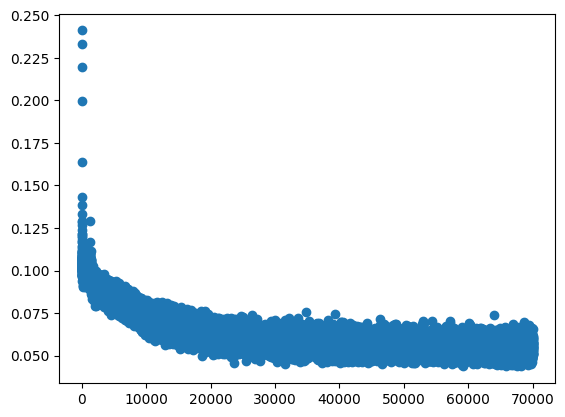

In [23]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

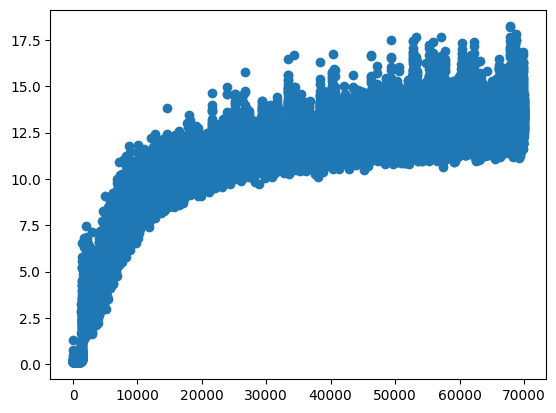

In [24]:
x=np.arange(len(n))
n=list(map(float, n))
plt.scatter(x,n)

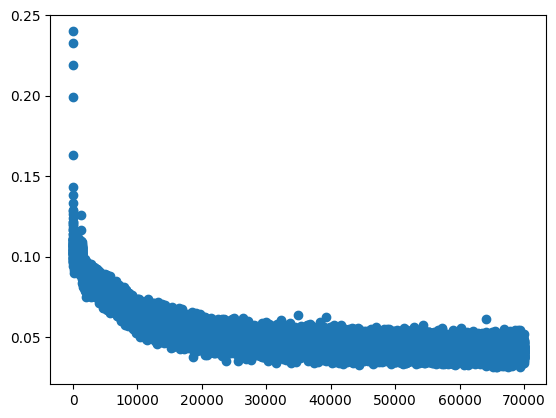

In [25]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

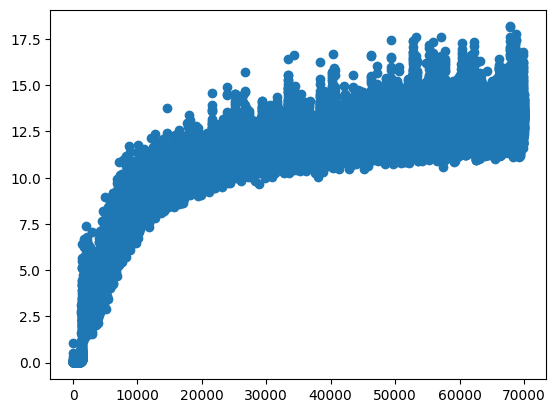

In [26]:
x=np.arange(len(k))
k=list(map(float, k))
plt.scatter(x,k)

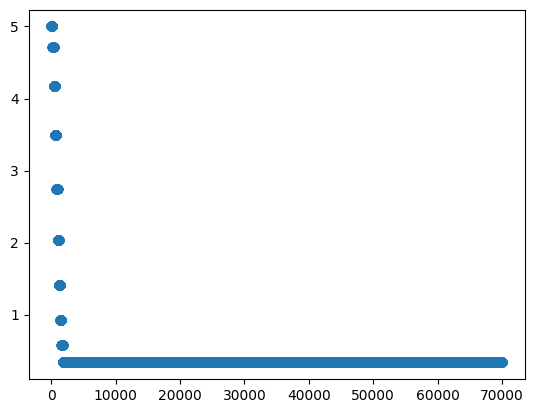

In [27]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [28]:
model.eval()


bVAE(
  (encoder): Sequential(
    (0): Linear(in_features=1250, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=500, bias=True)
    (7): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=1250, bias=True)
    (7): Sigmoid()
  )
)

In [29]:
def projection(x, beta=torch.Tensor([100]), eta=torch.Tensor([0.5])):
    
    return (torch.tanh(beta*eta) + torch.tanh(beta*(x-eta))) / (torch.tanh(beta*eta) + torch.tanh(beta*(1-eta)))

In [30]:
'''
test_design = np.load('/kaggle/input/dc-test/design_data255.npy', allow_pickle=True)
test_design=torch.from_numpy(test_design[0])
quarter_test_design = test_design[:200,:100]
plt.matshow(quarter_test_design)
quarter_test_design=quarter_test_design.flatten()
'''

"\ntest_design = np.load('/kaggle/input/dc-test/design_data255.npy', allow_pickle=True)\ntest_design=torch.from_numpy(test_design[0])\nquarter_test_design = test_design[:200,:100]\nplt.matshow(quarter_test_design)\nquarter_test_design=quarter_test_design.flatten()\n"

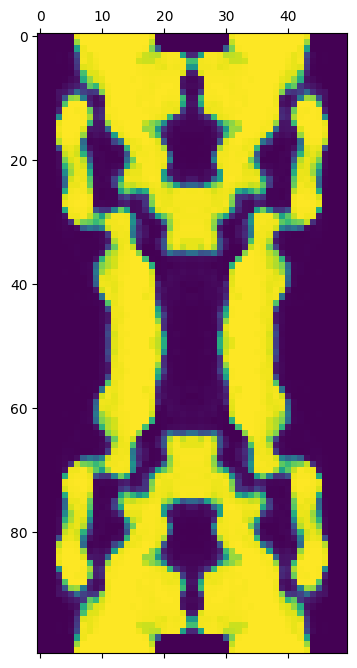

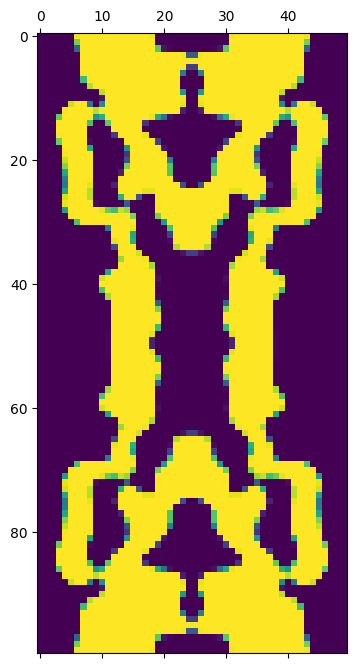

In [46]:
x=quarter_training_dataset[np.random.randint(480)]#quarter_test_design#quarter_design_dataset[np.random.randint(250)]
y=model(x.float().to(DEVICE))[0]
y=y.cpu().detach().numpy()
y=design_recover(y)
plt.matshow(y)

x1=x

x1=x1.cpu().detach().numpy()
plt.matshow(design_recover(x1))

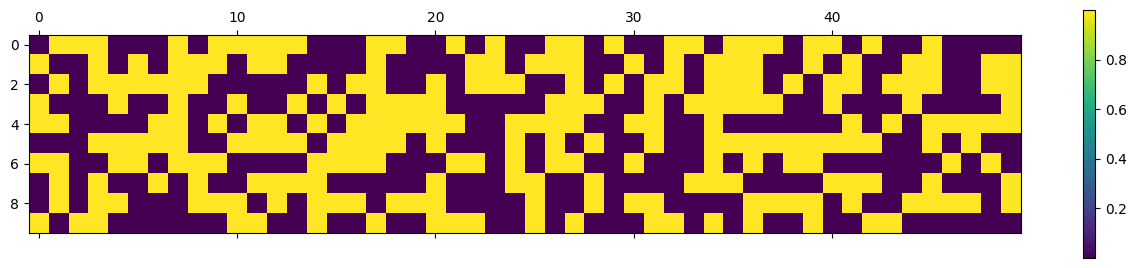

In [32]:
b=model(x.float().to(DEVICE))[1]
b=b.cpu().detach().numpy()
b=np.reshape(b,(10,50))
plt.matshow(b)
plt.colorbar()

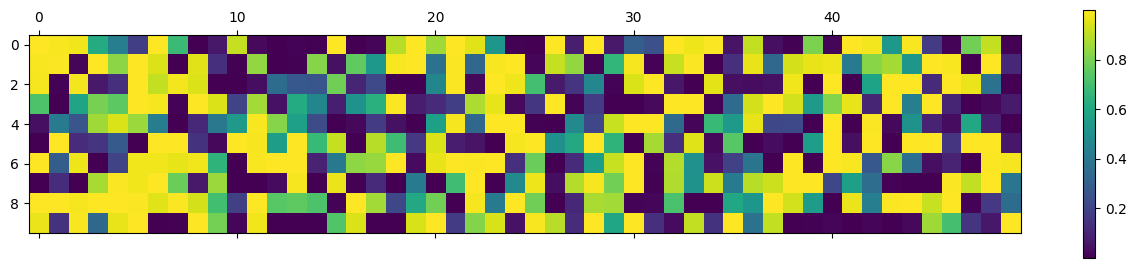

In [33]:
g=model(x.float().to(DEVICE))[2]
g=g.cpu().detach().numpy()
pl=g
g=np.reshape(g,(10,50))
plt.matshow(g)
plt.colorbar()

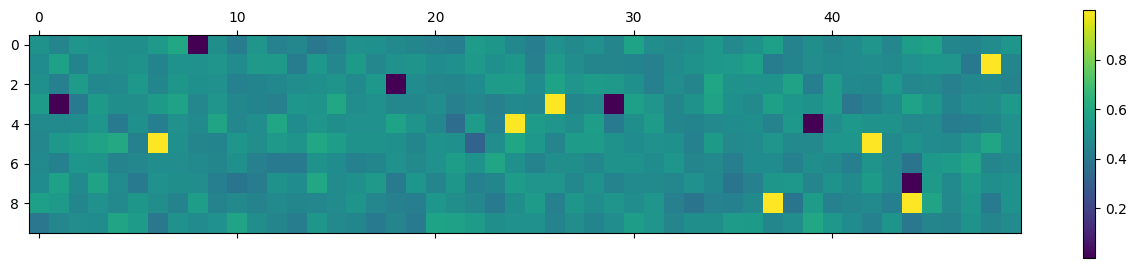

In [34]:
a=model(x.float().to(DEVICE))[3]
a=a.cpu().detach().numpy()
a=np.reshape(a,(10,50))
plt.matshow(a)
plt.colorbar()

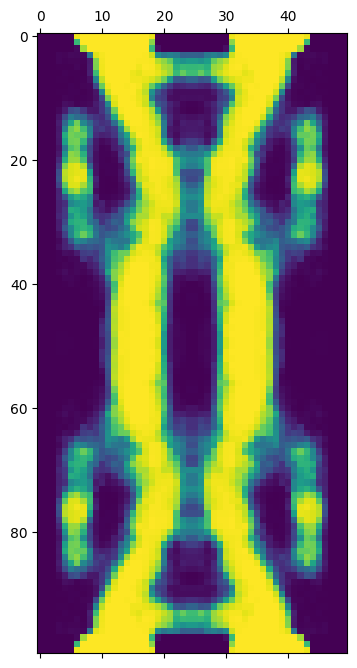

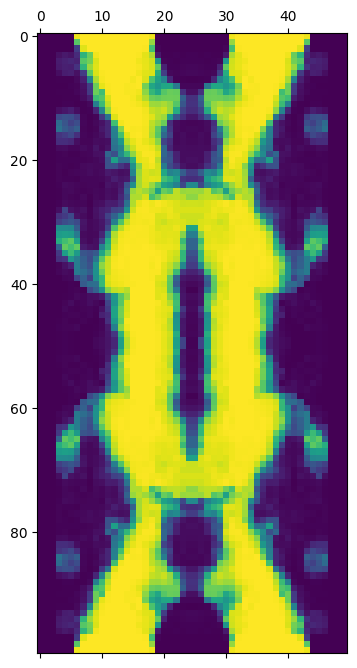

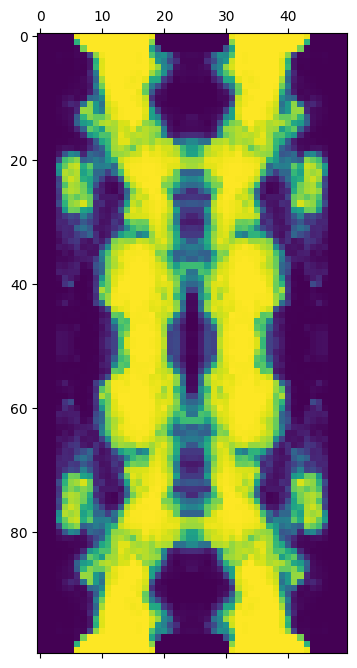

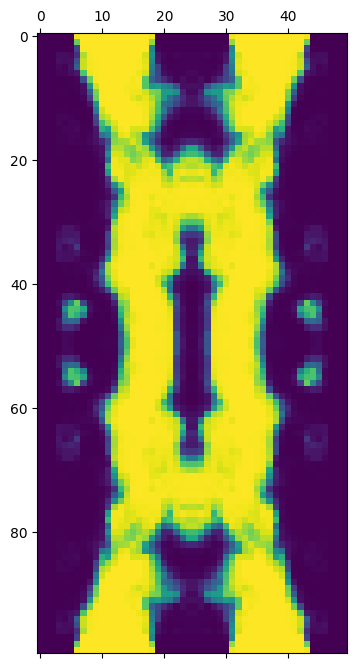

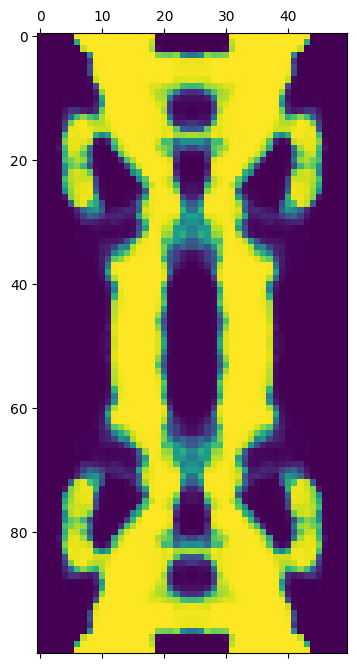

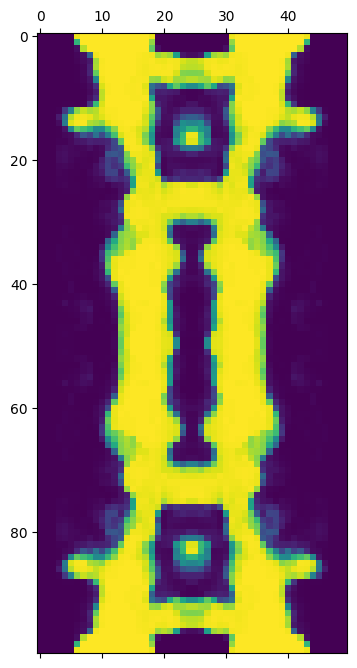

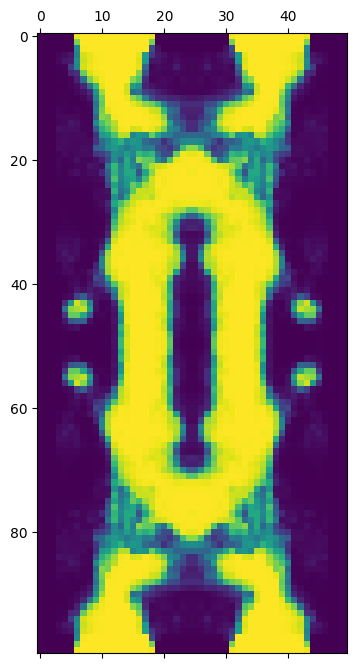

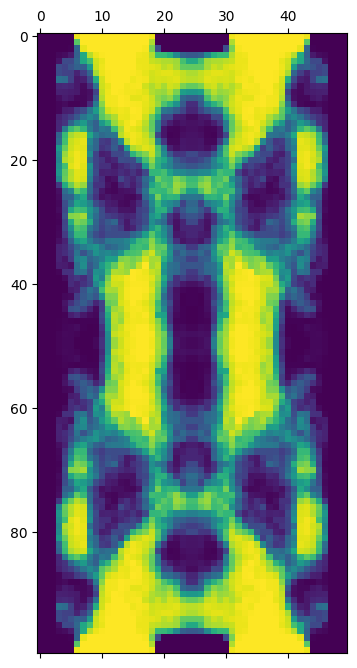

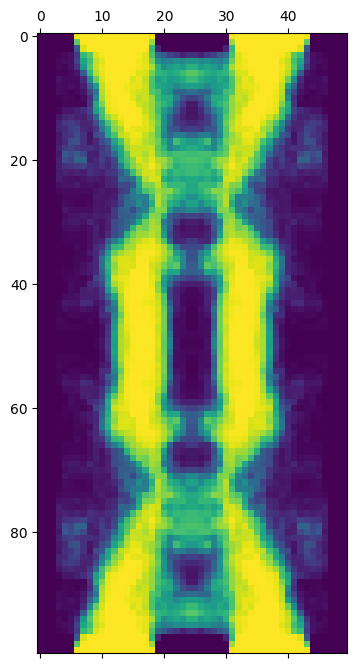

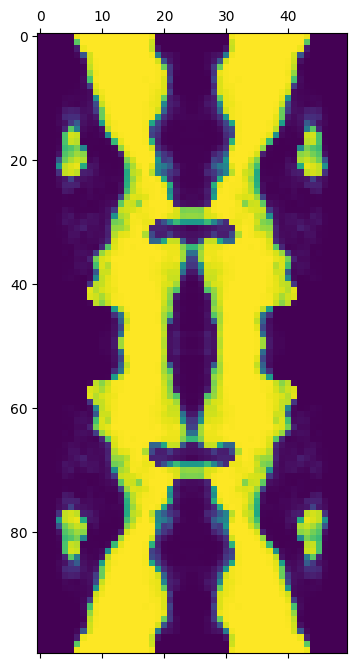

In [35]:
for i in range(10):
    a_check=torch.rand((latent_dim,))
    decoder_input=torch.bernoulli(a_check) .to(DEVICE)
    output=model.decode(decoder_input)
    
    output=output.cpu().detach().numpy()
    output=design_recover(output)
    #output=gaussian_filter(output, sigma=1)
    #output=projection(torch.Tensor(output))

    #output[output>0.1]=1
    #output[output<0.1]=0
    plt.matshow(output)

In [59]:
from skimage.transform import resize

model_output=[]

#better results with gaussian blur and projection
for i in range(2000):
    a_check=torch.rand((latent_dim,))
    decoder_input=torch.bernoulli(a_check) .to(DEVICE)
    output=model.decode(decoder_input)
    
    output=output.cpu().detach().numpy()
    output= np.reshape(output, (int(down_scaled_width*2/2), int(down_scaled_width/2)))
    #output=design_recover(output)
    #output=resize(output,(2*original_width/2,original_width/2))
    model_output.append(np.array(output))
    #output=gaussian_filter(output, sigma=1)
    #output=projection(torch.Tensor(output))

    #output[output>0.1]=1
    #output[output<0.1]=0
    #np.save('/kaggle/working/new_des'+str(i)+'.npy', output)
    #plt.matshow(output)

In [60]:
model_output=np.array(model_output)
model_output.shape

(2000, 50, 25)

In [61]:
np.save('model_output.npy', model_output)

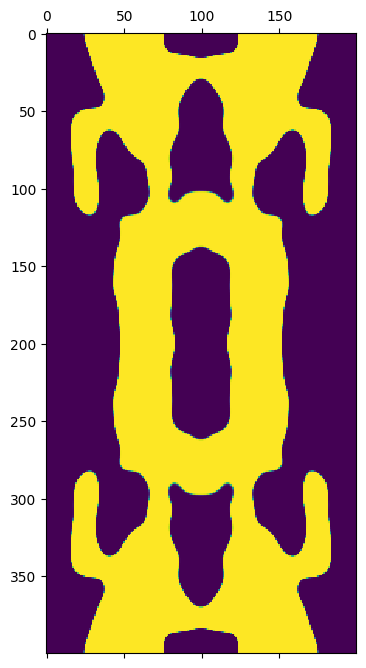

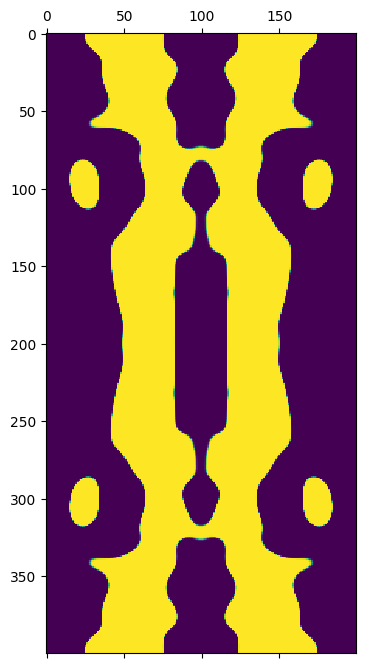

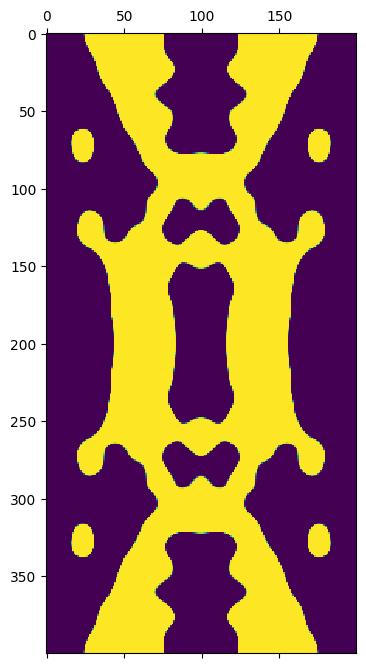

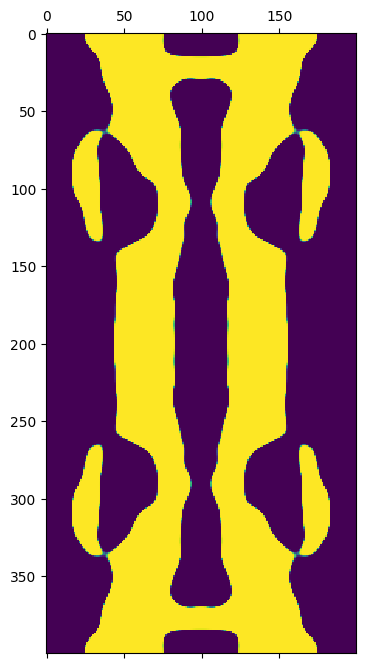

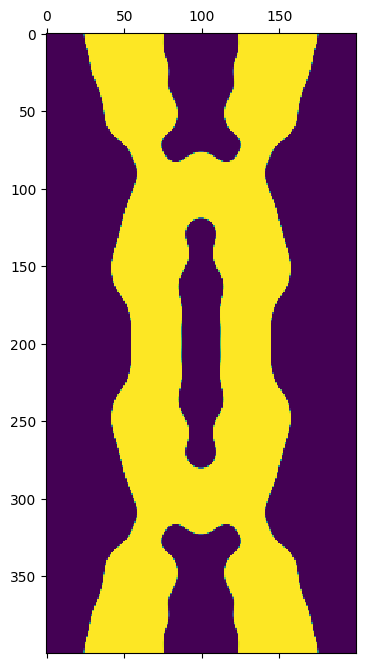

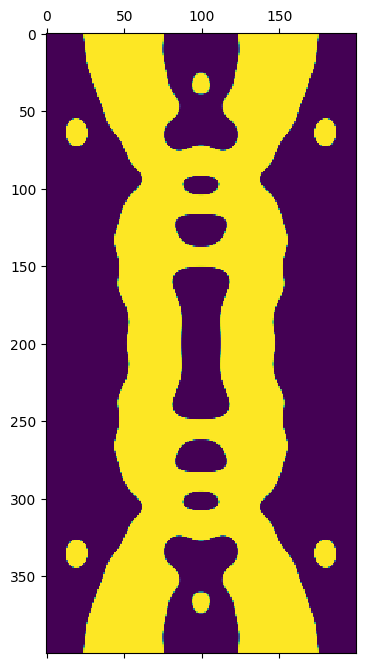

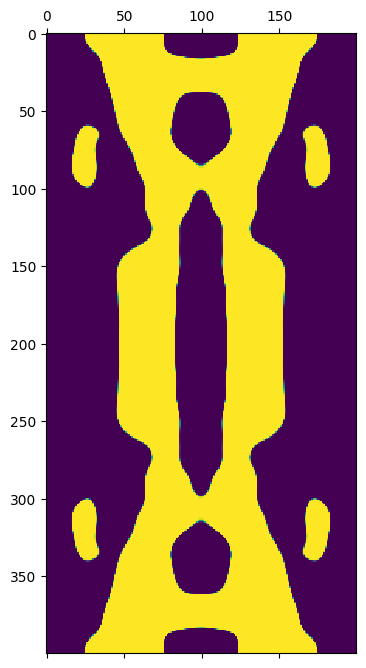

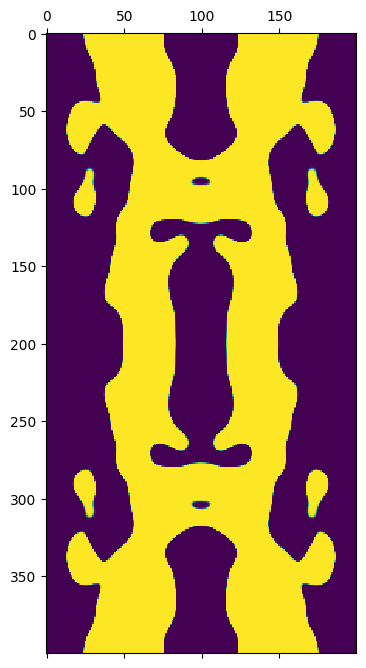

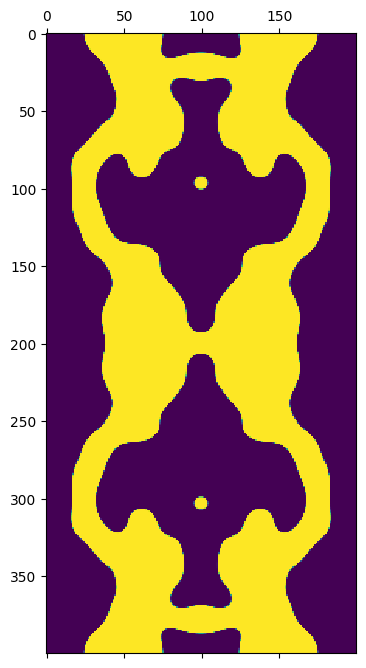

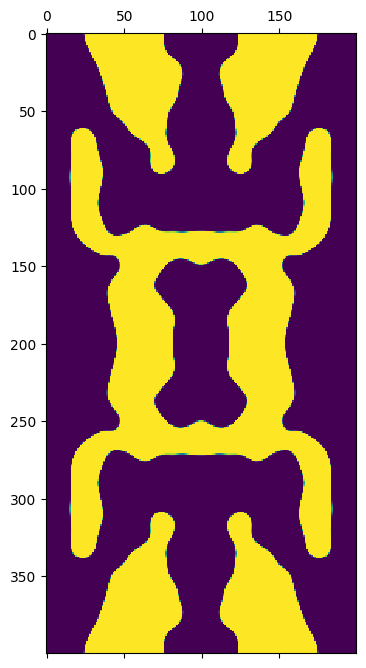

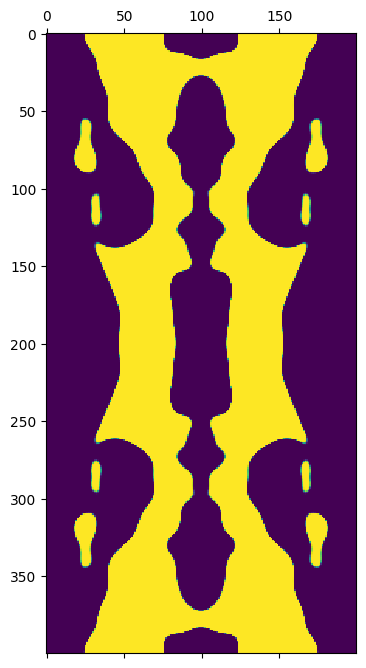

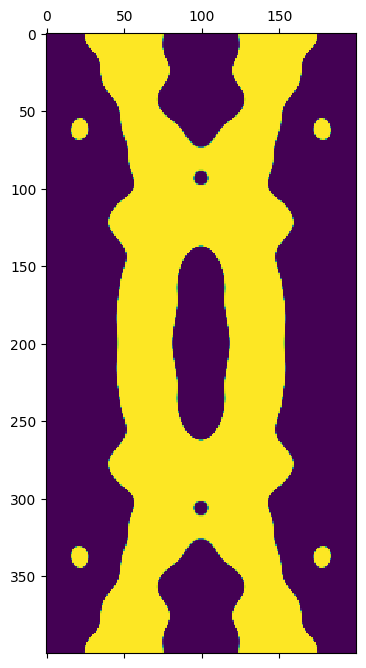

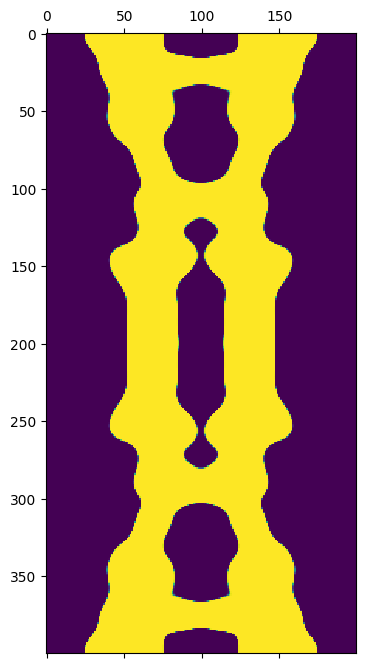

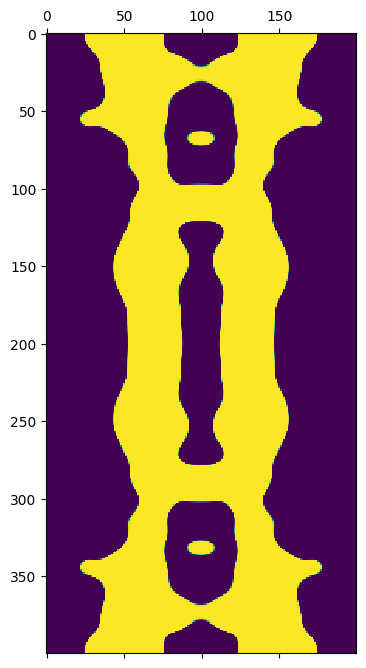

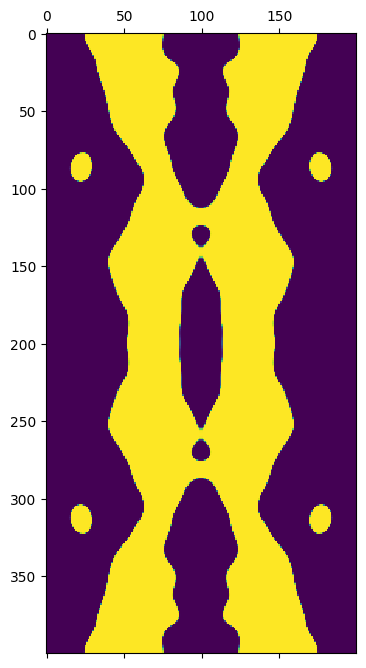

In [37]:
from skimage.transform import resize

generated_designs_pre_mapping2 = []

#better results with gaussian blur and projection
for i in range(15):
    a_check=torch.rand((latent_dim,))
    decoder_input=torch.bernoulli(a_check) .to(DEVICE)
    output=model.decode(decoder_input)
    
    output=output.cpu().detach().numpy()
    output=design_recover(output)
    output=resize(output,(2*original_width,original_width))
    output=gaussian_filter(output, sigma=4)
    output=projection(torch.Tensor(output))
    generated_designs_pre_mapping2.append(np.array(output))

    #output[output>0.1]=1
    #output[output<0.1]=0
    plt.matshow(output)
    #np.save('/kaggle/working/des'+str(i)+'.npy', output)

In [65]:
np.save('generated_designs_pre_mapping2.npy', generated_designs_pre_mapping2)